**Initialization**

In [28]:
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pyplot as plt

**Task 1: Data set**

The Cifar10 dataset comes directly in a two-part dataset for training and test data. The training dataset contains 50000 image-label pairs and the test dataset 10000 image-label pairs. The labels are displayed as numbers from 0 to 9. Among other things in the following code snippet these numbers are mapped to their string label class names. The images in the datasets come up with a fixed shape of 32 x 32 x 3. Thus no resizing is necessary. 

Additionally, some example images of the dataset are displayed with the corresponding string label class name.

Training inputs shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test inputs shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


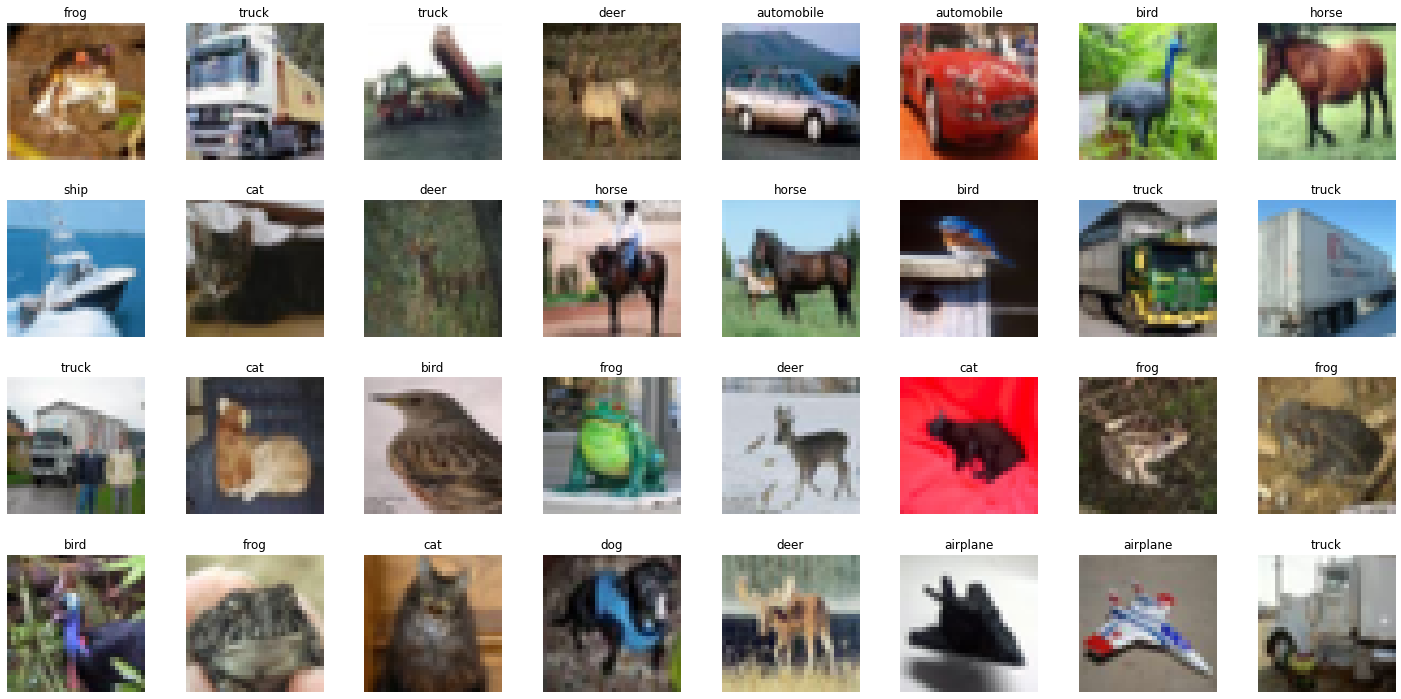

In [29]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i][-1]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Input pipeline

In [30]:
batch_size = 64

# Creates tensorflow datasets for the training and test data.
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
training_dataset = training_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))  # tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors.
test_dataset = test_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))     
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
training_dataset = training_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

**Task 2: Model**

**Task 2.1: ResNet**

Class ResidualBlock

In [36]:
# Description: The class ResidualBlock describes a residual block of a ResNet.
class ResidualBlock(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(ResidualBlock, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filters = 120,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                        
    self.activ_1 = tf.keras.activations.relu                          
    self.conv_2 = tf.keras.layers.Conv2D(filters = 120,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))       
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                        
    self.activ_2 = tf.keras.activations.relu
    self.dropout_2 = tf.keras.layers.Dropout(rate = 0.5)                                            
    self.conv_3 = tf.keras.layers.Conv2D(filters = 120,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))       
    self.batch_norm_3 = tf.keras.layers.BatchNormalization()                                        
    self.activ_3 = tf.keras.activations.relu


  # Description: This function conducts one forward-step of the residual block. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: block_input, training (to differ between training and test calls of the residual block)
  #              @returns: block_output
  @tf.function
  def call(self, block_input, training = True):
    x = self.conv_1(block_input)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.conv_2(x)
    x = self.batch_norm_2(x, training)
    x = self.activ_2(x)
    x = self.dropout_2(x, training)
    x = self.conv_3(x)
    x = self.batch_norm_3(x, training)
    x = self.activ_3(x)

    block_output = block_input + x
    return block_output

Class ResNet

In [32]:
# Description: The class ResNet describes a residual convolutional neural network with a feature extractor and a classifier.
class ResNet(tf.keras.Model): 
  
  def __init__(self, num_residual_blocks):
    super(ResNet, self).__init__()

    # Feature extractor
    self.conv_1 = tf.keras.layers.Conv2D(filters = 120,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                         bias_initializer = 'zeros',                               
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),      
                                         input_shape = (32, 32, 3))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                     
    self.activ_1 = tf.keras.activations.relu    
    self.dropout_1 = tf.keras.layers.Dropout(rate = 0.4)                                           

    self.residual_blocks = []
    for _ in range(num_residual_blocks):
      self.residual_blocks.append(ResidualBlock())

    # Classifier
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()   #pool_size = 3, strides = 2, padding = 'same'
    self.dropout = tf.keras.layers.Dropout(rate = 0.4)                                              
    self.output_layer = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)

  # Description: This function conducts one forward-step of the Residual CNN. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.dropout_1(x, training)

    for res_block in self.residual_blocks:
      x = res_block(x, training)

    x = self.global_pool(x)
    x = self.dropout(x, training)
    x = self.output_layer(x)
    return x

**Task 3: Training and Analysis**

In [33]:
# Description: This function conducts a forward-step and the backpropagation of a CNN. It does not matter whether the CNN is a ResNet or 
#              a DenseNet (this is defined by the parameter model). Additionally, the average training loss and accuracy is determined.
#              @parameters: model, training_data, loss_fn, optimizer, training (to differ between training and test calls of the CNN)
#              @returns: training_loss, training_accuracy
#@tf.function
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = model(input, training)
      current_training_loss = loss_fn(target, prediction)+ tf.math.reduce_sum(model.losses)   
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))  
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy


# Description: This function determines the average test loss and accuracy of a CNN. It does not matter 
#              whether the CNN is a ResNet or a DenseNet (this is defined by the parameter model).
#              @parameters: model, test_data, loss_fn, training (to differ between training and test calls of the CNN)
#              @returns: test_loss, test_accuracy
#@tf.function
def test(model, test_data, loss_fn, training = False):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = model(input, training)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

Epoch 0
Training accuracy: 0.18368366368286446
Test accuracy: 0.28403662420382164
Epoch 1
Training accuracy: 0.27449648337595906
Test accuracy: 0.3534036624203822
Epoch 2
Training accuracy: 0.3544996803069054
Test accuracy: 0.3916202229299363
Epoch 3
Training accuracy: 0.41376278772378516
Test accuracy: 0.5361265923566879
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3360      
_________________________________________________________________
batch_normalization (BatchNo multiple                  480       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
residual_block (ResidualBloc multiple                  160200    
_________________________________________________________________

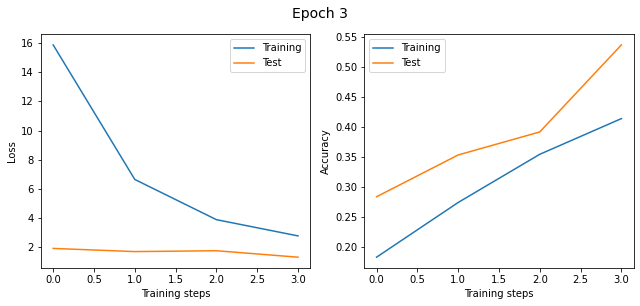

Epoch 4
Training accuracy: 0.45370444373401536
Test accuracy: 0.5324442675159236
Epoch 5
Training accuracy: 0.47919996803069054
Test accuracy: 0.5600119426751592
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3360      
_________________________________________________________________
batch_normalization (BatchNo multiple                  480       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
residual_block (ResidualBloc multiple                  160200    
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  160200    
_________________________________________________________________
residual_block_2 (ResidualBl 

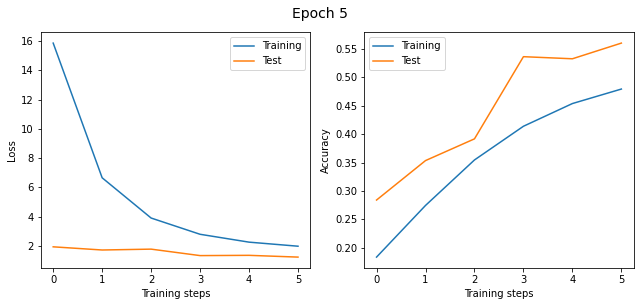

Epoch 6
Training accuracy: 0.5038762787723785
Test accuracy: 0.4817874203821656
Epoch 7
Training accuracy: 0.5200807225063938
Test accuracy: 0.5532444267515924
Epoch 8
Training accuracy: 0.5429587595907929
Test accuracy: 0.5406050955414012
Epoch 9
Training accuracy: 0.5556465792838875
Test accuracy: 0.5871815286624203
Epoch 10
Training accuracy: 0.5650975063938619
Test accuracy: 0.5659832802547771
Epoch 11
Training accuracy: 0.5762867647058824
Test accuracy: 0.5546377388535032
Epoch 12
Training accuracy: 0.5869765025575447
Test accuracy: 0.6202229299363057
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3360      
_________________________________________________________________
batch_normalization (BatchNo multiple                  480       
_________________________________________________________________
dropout (Dropout)       

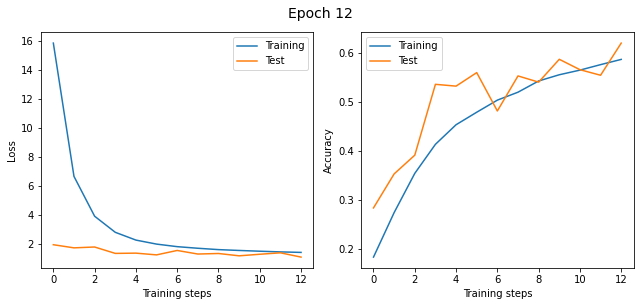

Epoch 13
Training accuracy: 0.5960477941176471
Test accuracy: 0.5822054140127388
Epoch 14
Training accuracy: 0.6064977621483376
Test accuracy: 0.6194267515923567
Epoch 15
Training accuracy: 0.6125719309462916
Test accuracy: 0.6401273885350318
Epoch 16
Training accuracy: 0.6197850063938619
Test accuracy: 0.5639928343949044
Epoch 17
Training accuracy: 0.6274976023017903
Test accuracy: 0.597531847133758
Epoch 18
Training accuracy: 0.6360693734015346
Test accuracy: 0.6690883757961783
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3360      
_________________________________________________________________
batch_normalization (BatchNo multiple                  480       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
____________________________________

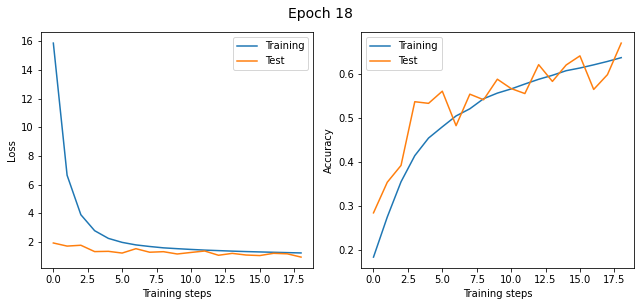

Epoch 19
Training accuracy: 0.6394261508951407
Test accuracy: 0.6192277070063694
Epoch 20
Training accuracy: 0.6424632352941176
Test accuracy: 0.642515923566879
Epoch 21
Training accuracy: 0.6504355818414322
Test accuracy: 0.6456011146496815
Epoch 22
Training accuracy: 0.654451726342711
Test accuracy: 0.6547571656050956
Epoch 23
Training accuracy: 0.6602461636828645
Test accuracy: 0.6628184713375797
Epoch 24
Training accuracy: 0.6643821930946292
Test accuracy: 0.681031050955414
Epoch 25
Training accuracy: 0.6673193734015346
Test accuracy: 0.6587380573248408
Epoch 26
Training accuracy: 0.6720947890025576
Test accuracy: 0.7039211783439491
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3360      
_________________________________________________________________
batch_normalization (BatchNo multiple                  480       
________

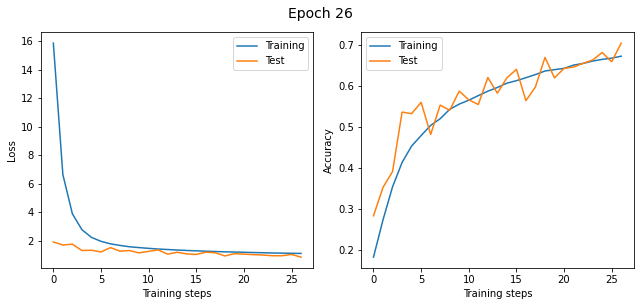

Epoch 27
Training accuracy: 0.6761708759590793
Test accuracy: 0.6828224522292994
Epoch 28
Training accuracy: 0.6806665601023018
Test accuracy: 0.5886743630573248
Epoch 29
Training accuracy: 0.6829843350383632
Test accuracy: 0.6717754777070064
Epoch 30
Training accuracy: 0.6849624360613811
Test accuracy: 0.6994426751592356
Epoch 31
Training accuracy: 0.6893781969309463
Test accuracy: 0.714968152866242
Epoch 32
Training accuracy: 0.6883591751918159
Test accuracy: 0.7129777070063694
Epoch 33
Training accuracy: 0.6964514066496164
Test accuracy: 0.6514729299363057
Epoch 34
Training accuracy: 0.6991088554987213
Test accuracy: 0.6891918789808917
Epoch 35
Training accuracy: 0.7016464194373402
Test accuracy: 0.7161624203821656
Epoch 36
Training accuracy: 0.7084998401534527
Test accuracy: 0.6640127388535032
Epoch 37
Training accuracy: 0.7083000319693095
Test accuracy: 0.7431329617834395
Epoch 38
Training accuracy: 0.7125159846547314
Test accuracy: 0.6937699044585988
Epoch 39
Training accuracy: 0

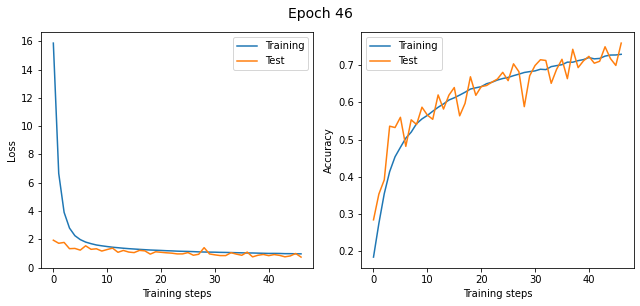

Epoch 47
Training accuracy: 0.7319373401534527
Test accuracy: 0.6792396496815286
Epoch 48
Training accuracy: 0.735673753196931
Test accuracy: 0.6685907643312102
Epoch 49
Training accuracy: 0.734994405370844
Test accuracy: 0.7138734076433121
Epoch 50
Training accuracy: 0.735673753196931
Test accuracy: 0.7274084394904459
Epoch 51
Training accuracy: 0.7370124680306905
Test accuracy: 0.6988455414012739
Epoch 52
Training accuracy: 0.7400095907928389
Test accuracy: 0.7553742038216561
Epoch 53
Training accuracy: 0.7410286125319693
Test accuracy: 0.6961584394904459
Epoch 54
Training accuracy: 0.7445652173913043
Test accuracy: 0.7477109872611465
Epoch 55
Training accuracy: 0.7468230498721228
Test accuracy: 0.7699044585987261
Epoch 56
Training accuracy: 0.7476023017902813
Test accuracy: 0.7145700636942676
Epoch 57
Training accuracy: 0.7436261189258312
Test accuracy: 0.7253184713375797
Epoch 58
Training accuracy: 0.7512587915601023
Test accuracy: 0.6610270700636943
Epoch 59
Training accuracy: 0.7

KeyboardInterrupt: ignored

In [37]:
# Description: This part creates objects of a ResNet and DenseNet and executes the training and testing of these models in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
#              In order to better monitor the training progress, the loss and accuracy graphs are provided in addtion to the numerical outputs when the test accuracy 
#              has significantly improved.
tf.keras.backend.clear_session()

num_residual_blocks = 6
model = ResNet(num_residual_blocks) 

n_epochs = 150
learning_rate = 0.00009
loss_fn = tf.keras.losses.CategoricalCrossentropy()                    # CategoricalCrossentropy because of 10 labels to differ.
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)    # Optimizer Adam (Adaptive Moment Estimation) with AMSGrad activated.

training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

dynamic_threshold_train_visio = 0.5                                    # Test accuracy threshold from which the training progress is displayed.
# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))

    training_loss, training_accuracy = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_fn, training = False)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print("Training accuracy: " + str(training_accuracy))
    print("Test accuracy: " + str(test_accuracy))

    # Visualization during training to check how the CNN is doing. In 5% steps of the test accuracy starting up from 50% test accuracy.
    if test_accuracy >= dynamic_threshold_train_visio: 
      model.summary()  

      fig, ax = plt.subplots(1,2, figsize=(9, 4))

      fig.suptitle(('Epoch ' + str(epoch)), fontsize=14, y=1.05)
      line1, = ax[0].plot(training_losses)
      line2, = ax[0].plot(test_losses)
      ax[0].set_xlabel("Training steps")
      ax[0].set_ylabel("Loss")
      ax[0].legend((line1, line2),("Training", "Test"))

      line1, = ax[1].plot(training_accuracies)
      line2, = ax[1].plot(test_accuracies)
      ax[1].set_xlabel("Training steps")
      ax[1].set_ylabel("Accuracy")
      ax[1].legend((line1, line2),("Training", "Test"))

      fig.tight_layout()
      plt.draw()
      plt.show()

      # Increases the test accuracy threshold by 5%.  
      dynamic_threshold_train_visio += 0.05

Visualization


In [ ]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the model.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()